# Fast Upsampling in a Single Forward Pass with FeatUp (JBU)

> ⚠️ Change your collab runtime to T4 GPU before running this notebook

In this notebook we will walk through how to load and work with our catalog of pre-trained upsamplers that work with common vision backbones such as CLIP, DINO, DINO v2, and ResNet50. We note that we add a Layer Norm operation to each of these backbones prior to upsampling so keep this in mind if you are trying to replace an existing component with one of our upsampled variants.

In [28]:
!git clone https://github.com/mhamilton723/FeatUp

Cloning into 'FeatUp'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 193 (delta 22), reused 28 (delta 12), pack-reused 152
Receiving objects: 100% (193/193), 55.59 MiB | 39.61 MiB/s, done.
Resolving deltas: 100% (78/78), done.


## Install FeatUp and our fast Joint Bilateral Upsampling (JBU) Kernel

> ⚠️ This cell will take 3-5 minutes to run because of cuda kernel compilation


In [3]:
import os
os.chdir("/home/toskov/FeatUp/")

In [30]:
!pip install -e .
!pip install git+https://github.com/mhamilton723/CLIP.git

Obtaining file:///content/FeatUp/FeatUp/FeatUp
  Preparing metadata (setup.py) ... done
  Attempting uninstall: featup
    Found existing installation: featup 0.1.2
    Uninstalling featup-0.1.2:
      Successfully uninstalled featup-0.1.2
  Running setup.py develop for featup
  Cloning https://github.com/mhamilton723/CLIP.git to /tmp/pip-req-build-uf1y_eh3
  Running command git clone --filter=blob:none --quiet https://github.com/mhamilton723/CLIP.git /tmp/pip-req-build-uf1y_eh3
  Resolved https://github.com/mhamilton723/CLIP.git to commit dce9d43cc659cb9a013745b378c78077fde6aac0
  Preparing metadata (setup.py) ... done


In [4]:
import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm
from featup.plotting import plot_feats

In [5]:
input_size = 224
image_path = "sample-images/plant.png"

transform = T.Compose([
    T.Resize(input_size),
    T.CenterCrop((input_size, input_size)),
    T.ToTensor(),
    norm
])

image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).cuda()

## DINO

/home/toskov/miniconda/envs/py38/lib/python3.8/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mhamilton723/FeatUp/zipball/main" to /home/toskov/.cache/torch/hub/main.zip
Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /home/toskov/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /ho

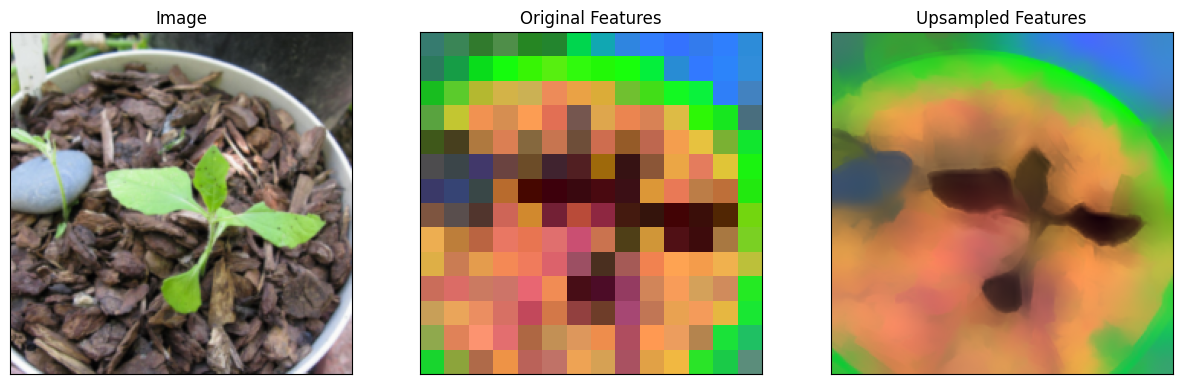

In [6]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dino16').cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])


## DINO v2

Using cache found in /home/toskov/.cache/torch/hub/mhamilton723_FeatUp_main
/home/toskov/FeatUp/featup/featurizers/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/toskov/FeatUp/featup/featurizers/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/toskov/FeatUp/featup/featurizers/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/toskov/.cache/torch/hub/main.zip
/home/toskov/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/toskov/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attenti

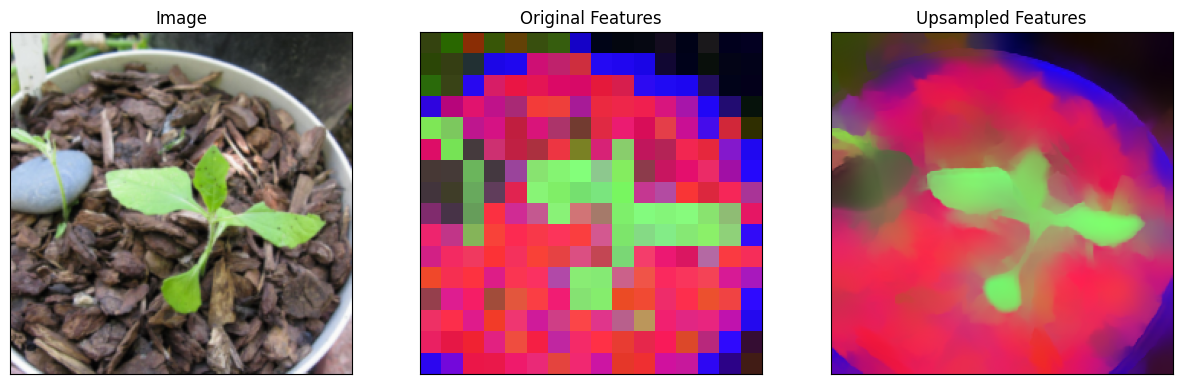

In [7]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dinov2').cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

In [15]:
type(upsampler)

hubconf.py.UpsampledBackbone

Using cache found in /home/toskov/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /home/toskov/.cache/torch/hub/facebookresearch_dinov2_main
Seed set to 0


torch.Size([1, 384, 256, 256])


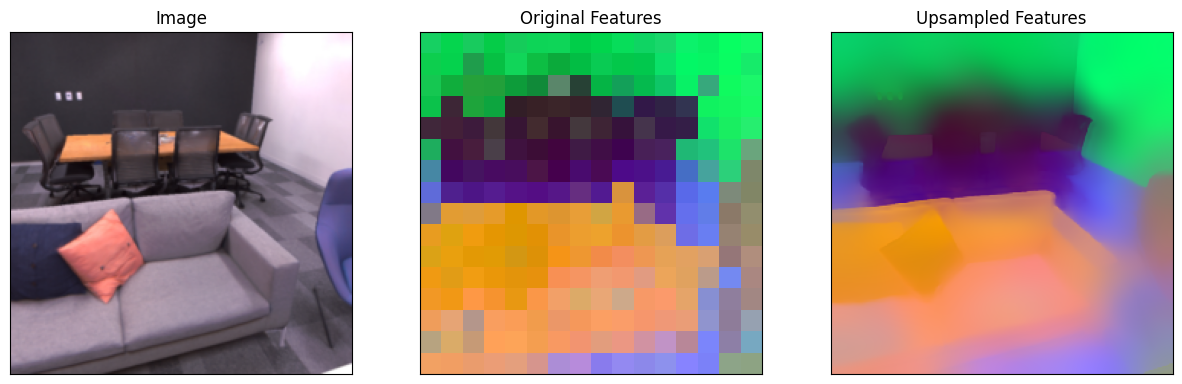

In [23]:
replica_img_path = "/scratch/toskov/data/nerfstudio_datasets/sdfstudio/replica/scan7/000077_rgb.png"

replica_image_tensor = transform(Image.open(replica_img_path).convert("RGB")).unsqueeze(0).cuda()

upsampler = torch.hub.load("mhamilton723/FeatUp", 'dinov2').cuda()
hr_feats = upsampler(replica_image_tensor)
print(hr_feats.shape)
lr_feats = upsampler.model(replica_image_tensor)
plot_feats(unnorm(replica_image_tensor)[0], lr_feats[0], hr_feats[0])

In [18]:
x = torch.load("/home/toskov/output/feats/exp1/image_folder/val/dinov2/000077_rgb.pth")
x.keys()

dict_keys(['model', 'downsampler', 'unprojector'])

torch.Size([1, 128, 16, 16])


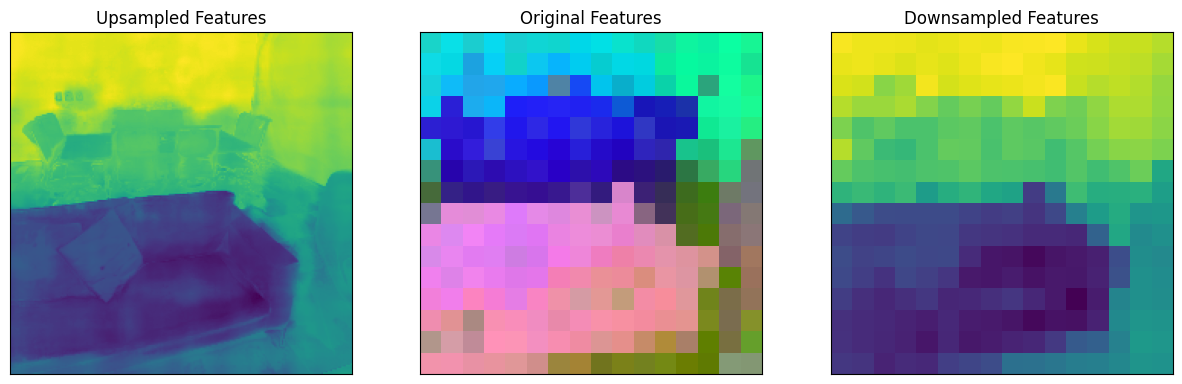

In [48]:
from featup.util import pca, remove_axes
import matplotlib.pyplot as plt
hr_feats = x["model"](replica_image_tensor)
[hr_pca], _ = pca(hr_feats.unsqueeze(0))

def mag(t):
    return t.square().sum(1, keepdim=True).sqrt()
hr_mag = mag(hr_feats)
hr_both = torch.cat([hr_mag, hr_feats], dim=1)

lr_feats = x["downsampler"](hr_both, None)
lr_feats = lr_feats[:, 1:, :, :]
print(lr_feats.shape)
[lr_pca], _ = pca(lr_feats.unsqueeze(0))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(hr_pca[0].permute(1,2,0).detach().cpu())
ax[0].set_title("Upsampled Features")

import torchvision
orig_pca = torchvision.io.read_image("/home/toskov/FeatUp/sample-images/low_res_feats.png")
ax[1].imshow(orig_pca.permute(1,2,0))
ax[1].set_title("Original Features")

ax[2].imshow(lr_pca[0].permute(1,2,0).detach().cpu())
ax[2].set_title("Downsampled Features")

remove_axes(ax)

## CLIP

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
INFO:lightning_fabric.utilities.seed:Seed set to 0


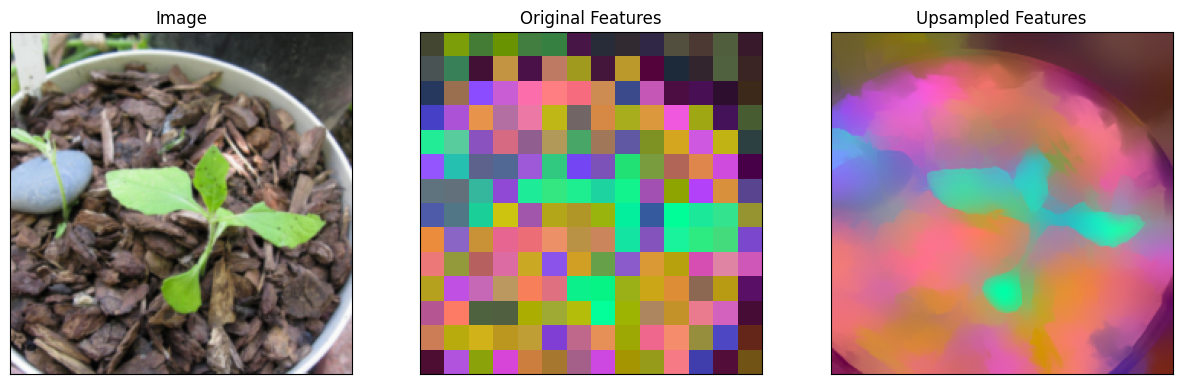

In [35]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'clip').cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

# ViT

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/vit_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/vit_jbu_stack_cocostuff.ckpt
100%|██████████| 2.04M/2.04M [00:00<00:00, 4.34MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


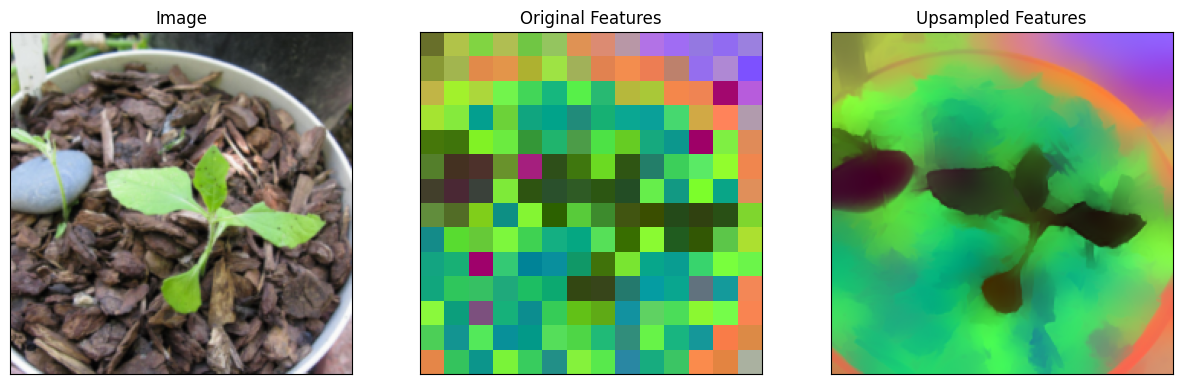

In [38]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'vit').cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

# ResNet 50

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
INFO:lightning_fabric.utilities.seed:Seed set to 0


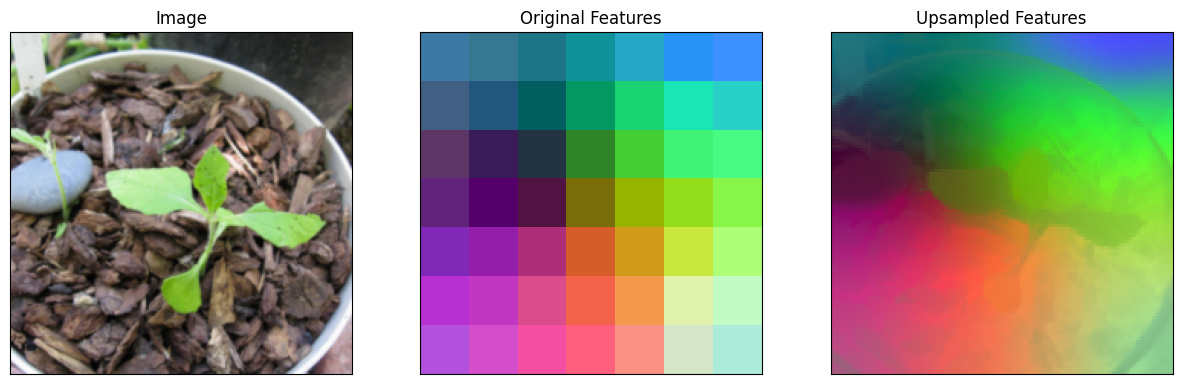

In [36]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'resnet50').cuda()
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

INFO:lightning_fabric.utilities.seed:Seed set to 0


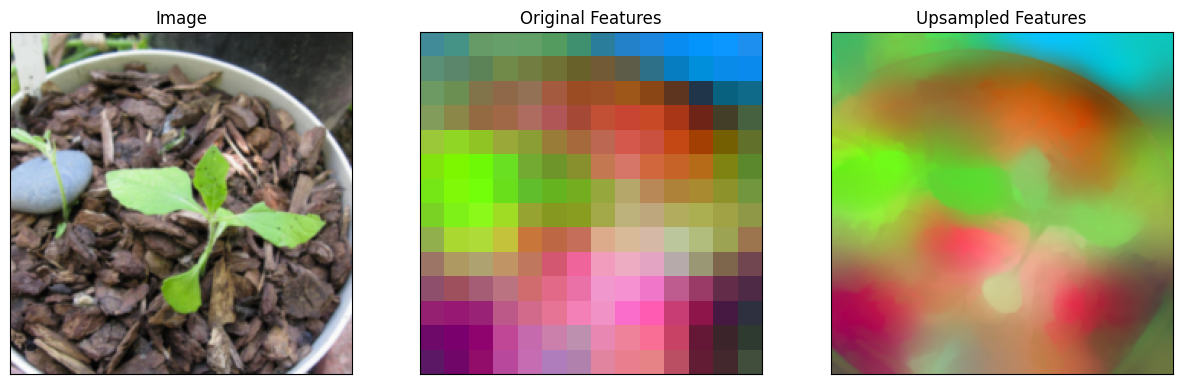

In [37]:
import torch.nn.functional as F

big_img = F.interpolate(image_tensor, scale_factor=2, mode='bilinear')
hr_feats = upsampler(big_img)
lr_feats = upsampler.model(big_img)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])